# Project 3 – Decision Tree Evaluation (Titanic Survival)
Andre Warsaw

Data 201

## Introduction
The goal of this project is to use a Decision Tree model to predict whether a Titanic passenger survived.
I chose the Titanic dataset because it is a well known real world crises along with the data set including both numeric and categorical variables,
which makes it ideal for visual exploration and for building an interpretable model.

## About the Data Set
The Titanic dataset used in this project contains 1,309 passenger records, with each row representing an individual who was aboard the Titanic.
The dataset includes a mix of demographic, family, and travel-related variables that provide context for understanding survival outcomes.
The target variable indicates whether a passenger survived, while the remaining variables serve as potential predictors.

- survived: Indicates whether the passenger survived '1' or did not survive '0'.
- pclass: Passenger class, with 1 representing first class, 2 representing second class, and 3 representing third class.
- sex: The passenger’s sex.
- age: The passenger’s age in years.
- sibsp: The number of siblings or spouses traveling with the passenger.
- parch: The number of parents or children traveling with the passenger.
- fare: The ticket fare paid by the passenger.
- embarked: The port where the passenger boarded the ship.



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
import pandas as pd

url = "https://hbiostat.org/data/repo/titanic3.xls"
df = pd.read_excel(url)

df.shape, df.head()

((1309, 14),
    pclass  survived                                             name     sex  \
 0       1         1                    Allen, Miss. Elisabeth Walton  female   
 1       1         1                   Allison, Master. Hudson Trevor    male   
 2       1         0                     Allison, Miss. Helen Loraine  female   
 3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
 4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   
 
        age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
 0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
 1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
 2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
 3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
 4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
 
                          home.dest

## Dataset Overview
In this section, I confirm the dataset size, check column types, and look for missing values.
This is not deep cleaning yet, it is just understanding what we are working with.

In [4]:
df.info()
df.isna().sum().sort_values(ascending=False).head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


,0
body,1188
cabin,1014
boat,823
home.dest,564
age,263
embarked,2
fare,1
sibsp,0
name,0
survived,0


## Survival Rate
First I want to understand the baseline: what percentage of passengers survived?
This matters because if survival is rare or common, accuracy can be misleading.


In [11]:
survival_rate = df["survived"].mean() if "survived" in df.columns else df["Survived"].mean()
survival_rate

np.float64(0.3819709702062643)

**Conclusion:**  
The baseline survival rate in this dataset is about 38.2%, which shows that most passengers did not survive.
This confirms that survival was not random and that certain factors likely played a meaningful role in determining outcomes.

This value also serves as an important reference point for the modeling stage.
Any predictive model should perform better than simply assuming all passengers did not survive, since that approach would already achieve an accuracy of around 62%.

## Survival by Sex
Next I compare survival rates across sex because historical patterns suggest survival differed across groups.
A bar chart is a simple way to compare proportions.

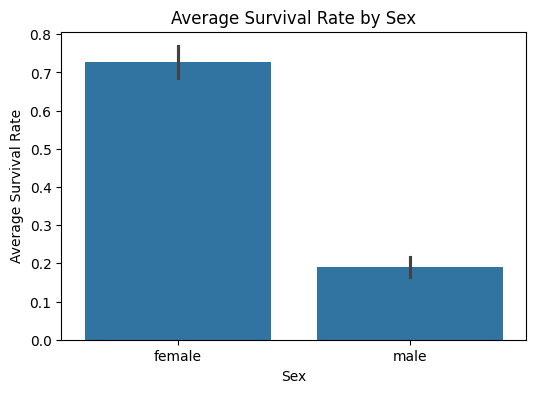

In [5]:
col_surv = "survived" if "survived" in df.columns else "Survived"
col_sex  = "sex" if "sex" in df.columns else "Sex"

plt.figure(figsize=(6,4))
sns.barplot(data=df, x=col_sex, y=col_surv)
plt.title("Average Survival Rate by Sex")
plt.xlabel("Sex")
plt.ylabel("Average Survival Rate")
plt.show()

**Conclusion:**  
The plot shows a clear difference in survival rates between female and male passengers.
Female passengers had a substantially higher average survival rate than male passengers, while male survival remained well below the overall baseline.

This suggests that sex was a major factor in survival outcomes and is likely to be a strong predictor in the decision tree model.
Including this variable should help the model make more accurate and meaningful splits when predicting survival.


##Survival by Passenger Class
Passenger class can represent access to resources and cabin location.
I compare survival by class to see if socioeconomic differences appear in the data.

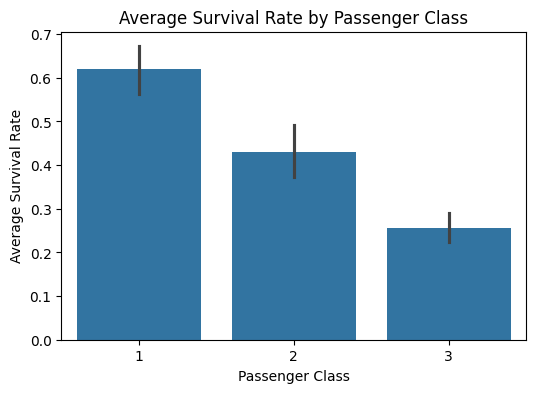

In [6]:
col_pclass = "pclass" if "pclass" in df.columns else "Pclass"

plt.figure(figsize=(6,4))
sns.barplot(data=df, x=col_pclass, y=col_surv)
plt.title("Average Survival Rate by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Average Survival Rate")
plt.show()

**Conclusion:**  
The plot shows a clear decline in survival rates as passenger class decreases.
First-class passengers had the highest average survival rate, followed by second-class passengers, while third-class passengers had the lowest survival rate.

This pattern suggests that passenger class is strongly associated with survival and likely captures differences in access to resources and ship location.
As a result, passenger class should be an important feature in the decision tree model and may appear near the top of the tree when making splits.

## Modeling Setup
A Decision Tree needs numeric inputs.  
Here I select a small set of features and do minimal preprocessing:
- Fill missing ages with the median
- Convert the categorical variables (such as sex, for example) and embark into numeric form using one-hot encoding so they could be used by the decision tree model.

In [7]:
# Standardize column names depending on dataset source
if "Survived" in df.columns:
    df = df.rename(columns={"Survived":"survived", "Pclass":"pclass", "Sex":"sex"})

# Minimal preprocessing for modeling
model_df = df[["survived", "pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]].copy()

model_df["age"] = model_df["age"].fillna(model_df["age"].median())
model_df["embarked"] = model_df["embarked"].fillna(model_df["embarked"].mode()[0])

model_df = pd.get_dummies(model_df, columns=["sex", "embarked"], drop_first=True)

X = model_df.drop(columns=["survived"])
y = model_df["survived"]

X.shape, y.shape

((1309, 8), (1309,))

## Train and Test Split
I split the data into training and testing sets so the model is evaluated on unseen data.
This gives a more realistic measure of performance.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

## Predictions and Evaluation
For classification, I produce:
- predicted class labels (survived or not)
- predicted probabilities (how confident the model is)
Then I evaluate accuracy and review a confusion matrix and classification report.

In [9]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
acc

confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

# show first 5 probability rows
y_prob[:5]

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       203
           1       0.80      0.75      0.77       125

    accuracy                           0.83       328
   macro avg       0.82      0.82      0.82       328
weighted avg       0.83      0.83      0.83       328



array([[0.84444444, 0.15555556],
       [0.58064516, 0.41935484],
       [0.93396226, 0.06603774],
       [0.84444444, 0.15555556],
       [0.17857143, 0.82142857]])

**Modeling Conclusion:**  
The decision tree model achieved an accuracy of 83%, showing strong overall performance on the test data.
The model was more effective at identifying passengers who did not survive than those who did, as reflected by higher precision and recall for the non-survival class.

Although the model captured meaningful survival patterns, the lower recall for survivors indicates that some surviving passengers were misclassified.
This suggests that while the model is useful, further refinement could improve its ability to identify survivors more consistently.

## Tree Visualization
Plotting the tree makes the model interpretable by showing which features it splits on first and how decisions are made.


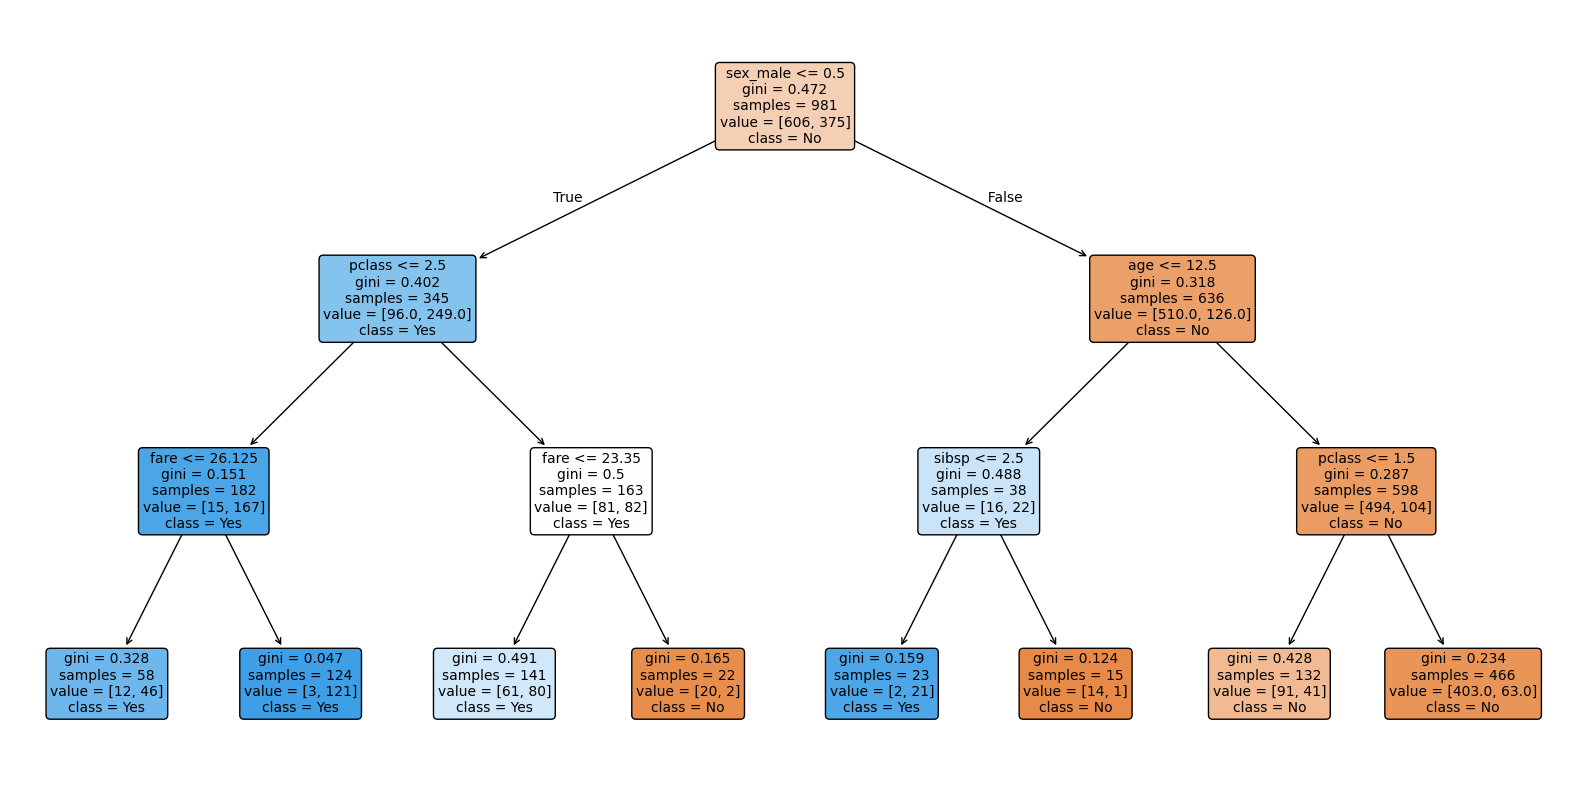

In [12]:
viz_model = DecisionTreeClassifier(max_depth=3, random_state=42)
viz_model.fit(X_train, y_train)

plt.figure(figsize=(20,10))
plot_tree(viz_model,
          feature_names=X.columns,
          class_names=["No", "Yes"],
          filled=True,
          rounded=True,
          fontsize=10)
plt.show()


This visualization was intentionally limited in depth to emphasize the most important decision patterns learned by the model.

### Conclusion
This simplified decision tree makes it clear which variables had the greatest influence on survival predictions.
The initial split on sex shows that this factor had the strongest overall impact on survival outcomes.

For female passengers, passenger class is the next most important factor.
Those traveling in first or second class were more likely to survive, with fare further refining outcomes within these groups.
This suggests that class and access to resources played a meaningful role in survival for female passengers.

For male passengers, age becomes the primary factor after the initial split.
Younger males were more likely to survive, while older males were more often classified as non-survivors.
Passenger class then helps distinguish outcomes within this group, with first-class males showing better survival rates than those in lower classes.

Overall, the structure of the tree closely reflects the patterns observed during exploratory data analysis.
The model relies first on sex, then on passenger class, fare, and age to make more refined and interpretable survival predictions.

# Final Conclusion

In this project, a decision tree classification model was used to predict survival outcomes using the Titanic passenger dataset.
Exploratory data analysis revealed clear patterns in survival, particularly across sex and passenger class, which suggested that survival was not random and depended on a combination of personal and travel-related factors.

The decision tree model achieved an accuracy of 83%, indicating strong overall performance on the test data.
The model was more effective at identifying passengers who did not survive than those who did, highlighting a tradeoff between overall accuracy and correctly identifying survivors.
The predicted class probabilities further showed that the model did not make uniform decisions and instead expressed varying levels of confidence across predictions.

The refined tree visualization reinforced the patterns observed during EDA.
Sex emerged as the most influential factor, followed by passenger class, fare, and age, all of which contributed to more detailed survival predictions.
Limiting the depth of the tree improved interpretability while preserving the main decision logic learned by the model.

Overall, the results show that a decision tree can effectively capture meaningful survival patterns while remaining interpretable.
While the model performs well, future improvements could further assist with more accurate predictions regarding survival rates.